In [1]:
#import tensorflow as tf
import numpy as np
import pandas as pd
#import holidays
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians

%matplotlib inline
#holiday_list = holidays.India(years=2016)

In [2]:
train_data = pd.read_csv(r"C:\Users\naoggu\Downloads\Hitachi Challenge\DataSet/train.csv")
test_data = pd.read_csv(r"C:\Users\naoggu\Downloads\Hitachi Challenge\DataSet/test.csv")
columns=train_data.drop(['id_code', 'target'], axis=1).columns
tot_data = pd.concat([train_data[columns], test_data[columns]])

In [3]:
train_data['current_datetime'] = pd.to_datetime(train_data['current_date']+' '+train_data['current_time'])
train_data['datetime'] = pd.to_datetime(train_data['current_date']+' '+train_data['current_time'])
test_data['current_datetime'] = pd.to_datetime(test_data['current_date']+' '+test_data['current_time'])
test_data['datetime'] = pd.to_datetime(test_data['current_date']+' '+test_data['current_time'])

In [4]:
source_station = tot_data[['source_name', 'country_code_source', 'longitude_source', 'latitude_source', 'mean_halt_times_source']]
destination_station = tot_data[['destination_name', 'country_code_destination', 'longitude_destination', 'latitude_destination', 'mean_halt_times_destination']]
source_station.columns=['name', 'country_code', 'latitude', 'longitude', 'mean_halt_times']
destination_station.columns=['name', 'country_code', 'latitude', 'longitude', 'mean_halt_times']

In [5]:
station_detail = pd.concat([source_station, destination_station])
station_detail['id'] = station_detail['name'].apply(lambda x: int(x[8:]))
station_detail = station_detail.drop_duplicates()
station_detail.sort_values('id', inplace=True)
station_detail.reset_index(drop=True, inplace=True)
station_detail = station_detail.fillna(method = 'bfill')
station_detail

,name,country_code,latitude,longitude,mean_halt_times,id
0,station$0,logbp,-0.126061,51.531040,0.000000,0
1,station$1,logbp,-0.126061,51.531040,0.000000,1
2,station$2,logbp,-0.126061,51.531040,0.000000,2
3,station$3,logbp,0.321070,51.443040,0.000000,3
4,station$11,zxdec,6.958823,50.942721,12.540462,11
...,...,...,...,...,...,...
304,station$640,whber,2.999286,50.772072,22.445087,640
305,station$642,whber,2.736343,50.854449,22.445087,642
306,station$643,whber,3.130412,50.949025,35.274566,643
307,station$644,whber,3.212088,50.921149,35.274566,644


In [6]:
station_dict = {}
for x,y in zip(station_detail['name'], station_detail['id']):
    station_dict[x] = y

In [7]:
country_code = station_detail['country_code'].sort_values()
country_code = country_code.drop_duplicates()
country_code.reset_index(drop=True, inplace=True)
country_code = country_code.reset_index(drop=False)
country_code.columns=['id', 'code']
country_code

,id,code
0,0,aqfre
1,1,logbp
2,2,qwnll
3,3,whber
4,4,wsluu
5,5,zxdec


In [8]:
country_dict={}
for x,y in zip(country_code['code'], country_code['id']):
    country_dict[x]=y

In [9]:
train_detail = train_data.loc[:,['id_code', 'current_datetime', 'train_name', 'source_name', 'destination_name', 'target']]
train_detail = train_detail.drop_duplicates()
train_detail.sort_values('current_datetime', inplace=True)
train_detail.reset_index(drop=True, inplace=True)
train_detail.reset_index(inplace=True)
train_detail.rename(columns={'current_datetime':'datetime', 'index':'train_id', 'target':'passenger_demand', 
                             'source_name':'source', 'destination_name': 'destination'}, inplace=True)
train_detail

,train_id,id_code,datetime,train_name,source,destination,passenger_demand
0,0,isfywypmkqqhyft,2016-07-27 20:05:51,ICZVZS,station$147,station$1,high
1,1,mqsfxyvuqpbwomk,2016-07-27 20:06:11,ICZVZS,station$147,station$1,high
2,2,alspwwtbdvqsgby,2016-07-27 20:08:57,ICZVZS,station$147,station$1,high
3,3,szitxhhqduyrqpg,2016-07-27 20:09:08,ICZVZS,station$147,station$1,high
4,4,krisdqzczivvwcp,2016-07-27 20:11:01,ICZVZS,station$147,station$1,high
...,...,...,...,...,...,...,...
1279,1279,gfnxmbjcdyjdbeo,2016-10-05 15:12:10,ICZVZY,station$130,station$279,medium
1280,1280,mcfgyjeuatomuub,2016-10-05 18:14:27,ICWZZV,station$544,station$266,medium
1281,1281,rwhslfljqeapqhw,2016-10-05 18:23:44,SZZTSS,station$147,station$159,high
1282,1282,xcseqqecaatslst,2016-10-05 18:27:34,ICYAXR,station$147,station$422,low


In [10]:
train_dict = {}
for x,y in zip(train_detail['train_name'], train_detail['train_id']):
    train_dict[x] = y

In [11]:
station_detail['country_code'] = station_detail['country_code'].apply(lambda x: country_dict[x])
train_detail['source'] = train_detail['source'].apply(lambda x: station_dict[x])
train_detail['destination'] = train_detail['destination'].apply(lambda x: station_dict[x])

In [12]:
def get_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

In [13]:
train_data = train_detail.merge(station_detail, left_on='source', right_on='id', how='left')

In [14]:
train_data = train_data.merge(station_detail, left_on='source', right_on='id', how='left', suffixes=('_source', '_destination'))

In [15]:
train_data['distance_between_stations'] = get_distance(train_data['latitude_source'].values, train_data['longitude_source'].values, 
                                                       train_data['latitude_destination'].values, train_data['longitude_destination'].values)

In [16]:
datetime_detail = pd.DataFrame(pd.date_range('2016-06-01', '2016-11-30', freq='s'), columns=['datetime'])
datetime_detail['datetime'] = pd.to_datetime(datetime_detail['datetime'])

In [17]:
datetime_detail['day'] = datetime_detail['datetime'].dt.weekday.astype(int)
datetime_detail['is_weekend']=0
datetime_detail.loc[datetime_detail['day']>4, 'is_weekend']=1
datetime_detail['hours'] = datetime_detail['datetime'].dt.hour.astype(int)
datetime_detail['minutes'] = datetime_detail['datetime'].dt.minute.astype(int)
test_data['hours'] = test_data['datetime'].dt.hour
test_data['minutes'] = test_data['datetime'].dt.month.astype(int)
test_data['is_weekend'] = (test_data['is_weekend']*1).astype(int)

In [18]:
train_data = train_data.merge(datetime_detail, on='datetime', how='left')

In [19]:
train_data

,train_id,id_code,datetime,train_name,source,destination,passenger_demand,name_source,country_code_source,latitude_source,...,country_code_destination,latitude_destination,longitude_destination,mean_halt_times_destination,id_destination,distance_between_stations,day,is_weekend,hours,minutes
0,0,isfywypmkqqhyft,2016-07-27 20:05:51,ICZVZS,147,1,high,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,20,5
1,1,mqsfxyvuqpbwomk,2016-07-27 20:06:11,ICZVZS,147,1,high,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,20,6
2,2,alspwwtbdvqsgby,2016-07-27 20:08:57,ICZVZS,147,1,high,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,20,8
3,3,szitxhhqduyrqpg,2016-07-27 20:09:08,ICZVZS,147,1,high,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,20,9
4,4,krisdqzczivvwcp,2016-07-27 20:11:01,ICZVZS,147,1,high,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,20,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,1279,gfnxmbjcdyjdbeo,2016-10-05 15:12:10,ICZVZY,130,279,medium,station$130,3,4.360846,...,3,4.360846,50.859663,640.265896,130,0.0,2,0,15,12
1280,1280,mcfgyjeuatomuub,2016-10-05 18:14:27,ICWZZV,544,266,medium,station$544,3,3.710675,...,3,3.710675,51.035896,309.014451,544,0.0,2,0,18,14
1281,1281,rwhslfljqeapqhw,2016-10-05 18:23:44,SZZTSS,147,159,high,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,18,23
1282,1282,xcseqqecaatslst,2016-10-05 18:27:34,ICYAXR,147,422,low,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,18,27


columns = train_data.columns
train_columns = columns.drop(['id_code', 'target', 'current_date', 'current_time', 'current_year'])
categoricals = ['source_name', 'destination_name', 'train_name', 'country_code_source', 'country_code_destination', 'current_week', 
                'current_day', 'is_weekend', 'season', 'hour', 'current_month', 'is_holiday']

In [20]:
train_data.isna().sum()

train_id                       0
id_code                        0
datetime                       0
train_name                     0
source                         0
destination                    0
passenger_demand               0
name_source                    0
country_code_source            0
latitude_source                0
longitude_source               0
mean_halt_times_source         0
id_source                      0
name_destination               0
country_code_destination       0
latitude_destination           0
longitude_destination          0
mean_halt_times_destination    0
id_destination                 0
distance_between_stations      0
day                            0
is_weekend                     0
hours                          0
minutes                        0
dtype: int64

In [21]:
train_data['passenger_demand_high'] = np.where(train_data['passenger_demand']=='high', 1, 0)
train_data['passenger_demand_medium'] = np.where(train_data['passenger_demand']=='medium', 1, 0)
train_data['passenger_demand_low'] = np.where(train_data['passenger_demand']=='low', 1, 0)

C:\Users\naoggu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


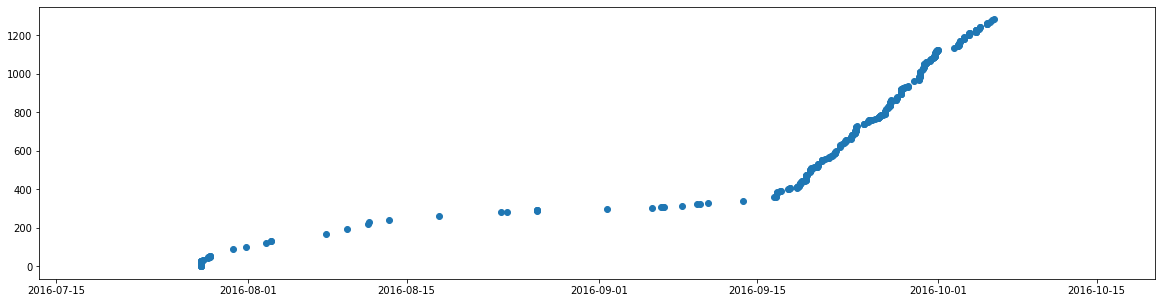

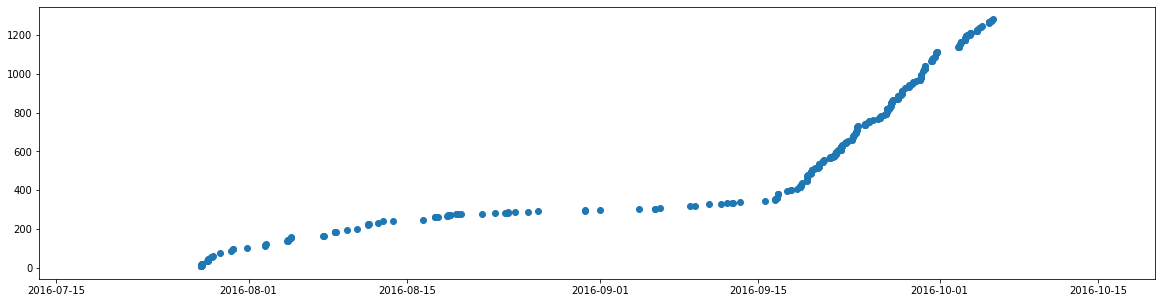

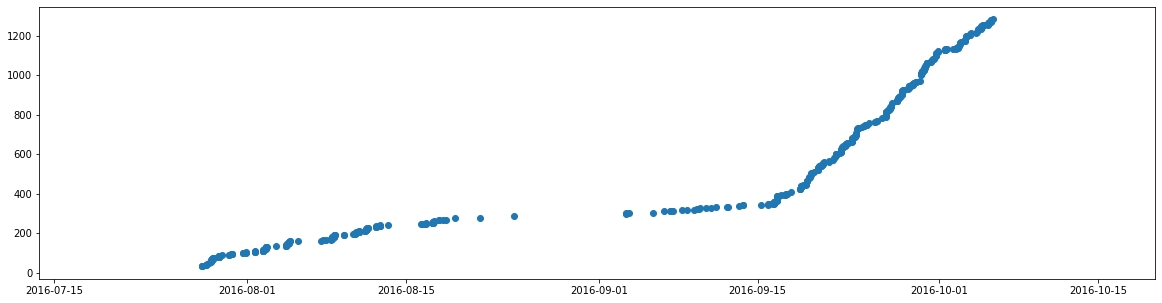

In [22]:
x_values = train_data.loc[train_data['passenger_demand']=='high', 'datetime']
y_values = train_data.loc[train_data['passenger_demand']=='high', 'train_id']
plt.figure(figsize=(20,5))
#plt.yticks(range(48,53))
#plt.xticks(range(-3,10))
plt.scatter(x_values, y_values)
x_values = train_data.loc[train_data['passenger_demand']=='medium', 'datetime']
y_values = train_data.loc[train_data['passenger_demand']=='medium', 'train_id']
plt.figure(figsize=(20,5))
plt.scatter(x_values, y_values)
x_values = train_data.loc[train_data['passenger_demand']=='low', 'datetime']
y_values = train_data.loc[train_data['passenger_demand']=='low', 'train_id']
plt.figure(figsize=(20,5))
plt.scatter(x_values, y_values)

In [23]:
trains_df = train_data.groupby(['train_name'])['passenger_demand_high', 'passenger_demand_medium', 'passenger_demand_low'].mean()
trains_df.columns = ['train_high_prob', 'train_low_prob', 'train_medium_prob']
trains_df

,train_high_prob,train_low_prob,train_medium_prob
train_name,,,
EURRZAS,0.0,1.000000,0.000000
ICRYVY,0.0,1.000000,0.000000
ICRYVZ,0.0,1.000000,0.000000
ICRYWA,1.0,0.000000,0.000000
ICRYZV,1.0,0.000000,0.000000
...,...,...,...
XUWA,0.4,0.400000,0.200000
XWZV,0.5,0.375000,0.125000
XXZV,0.0,0.000000,1.000000


In [24]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
trains_low = trains_df[trains_df['train_low_prob']==1].index
trains_medium = trains_df[trains_df['train_medium_prob']==1].index
trains_high = trains_df[trains_df['train_high_prob']==1].index
print(len(trains_low), len(trains_medium), len(trains_high))
print(intersection(trains_low, trains_medium), intersection(trains_medium, trains_low))
print(intersection(trains_medium, trains_high), intersection(trains_high, trains_medium))
print(intersection(trains_high, trains_low), intersection(trains_low, trains_high))

99 194 116
[] []
[] []
[] []


In [25]:
trains_df.reset_index(inplace=True)
train_data = train_data.merge(trains_df, left_on='train_name', right_on = 'train_name', how='left')

In [26]:
train_data['passenger_demand'] = np.where(train_data['passenger_demand']=='low', 0, 
                                          np.where(train_data['passenger_demand']=='medium', 1, 2))

In [27]:
train_data

,train_id,id_code,datetime,train_name,source,destination,passenger_demand,name_source,country_code_source,latitude_source,...,day,is_weekend,hours,minutes,passenger_demand_high,passenger_demand_medium,passenger_demand_low,train_high_prob,train_low_prob,train_medium_prob
0,0,isfywypmkqqhyft,2016-07-27 20:05:51,ICZVZS,147,1,2,station$147,3,4.356801,...,2,0,20,5,1,0,0,0.444444,0.138889,0.416667
1,1,mqsfxyvuqpbwomk,2016-07-27 20:06:11,ICZVZS,147,1,2,station$147,3,4.356801,...,2,0,20,6,1,0,0,0.444444,0.138889,0.416667
2,2,alspwwtbdvqsgby,2016-07-27 20:08:57,ICZVZS,147,1,2,station$147,3,4.356801,...,2,0,20,8,1,0,0,0.444444,0.138889,0.416667
3,3,szitxhhqduyrqpg,2016-07-27 20:09:08,ICZVZS,147,1,2,station$147,3,4.356801,...,2,0,20,9,1,0,0,0.444444,0.138889,0.416667
4,4,krisdqzczivvwcp,2016-07-27 20:11:01,ICZVZS,147,1,2,station$147,3,4.356801,...,2,0,20,11,1,0,0,0.444444,0.138889,0.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,1279,gfnxmbjcdyjdbeo,2016-10-05 15:12:10,ICZVZY,130,279,1,station$130,3,4.360846,...,2,0,15,12,0,1,0,0.000000,1.000000,0.000000
1280,1280,mcfgyjeuatomuub,2016-10-05 18:14:27,ICWZZV,544,266,1,station$544,3,3.710675,...,2,0,18,14,0,1,0,0.000000,1.000000,0.000000
1281,1281,rwhslfljqeapqhw,2016-10-05 18:23:44,SZZTSS,147,159,2,station$147,3,4.356801,...,2,0,18,23,1,0,0,1.000000,0.000000,0.000000
1282,1282,xcseqqecaatslst,2016-10-05 18:27:34,ICYAXR,147,422,0,station$147,3,4.356801,...,2,0,18,27,0,0,1,0.000000,0.333333,0.666667


In [28]:
stations_df = train_data.groupby(['source', 'destination'])['passenger_demand_high', 'passenger_demand_medium', 'passenger_demand_low'].mean()
stations_df.columns = ['station_high_prob', 'station_low_prob', 'station_medium_prob']
stations_df

station_high_prob  station_low_prob  station_medium_prob
source destination                                                          
0      643                   1.000000               0.0             0.000000
2      3                     0.000000               1.0             0.000000
25     178                   0.000000               0.0             1.000000
36     178                   0.000000               1.0             0.000000
89     130                   0.000000               0.2             0.800000
...                               ...               ...                  ...
643    549                   0.666667               0.0             0.333333
       632                   0.000000               1.0             0.000000
       644                   0.000000               1.0             0.000000
645    0                     0.000000               1.0             0.000000
       632                   1.000000               0.0             0.000000

[590 rows x 3 columns]

In [29]:
stations_low = stations_df[stations_df['station_low_prob']==1].index
stations_medium = stations_df[stations_df['station_medium_prob']==1].index
stations_high = stations_df[stations_df['station_high_prob']==1].index
print(len(stations_low), len(stations_medium), len(stations_high))
print(intersection(stations_low, stations_medium), intersection(stations_medium, stations_low))
print(intersection(stations_medium, stations_high), intersection(stations_high, stations_medium))
print(intersection(stations_high, stations_low), intersection(stations_low, stations_high))

126 196 119
[] []
[] []
[] []


In [30]:
#stations_df.reset_index(inplace=True)
train_data = train_data.merge(stations_df, left_on=['source', 'destination'], right_on = ['source', 'destination'], how='left')

In [31]:
len(intersection(train_data['train_name'].unique(), test_data['train_name'].unique())), len(intersection(test_data['train_name'].unique(), train_data['train_name'].unique()))

(199, 199)

In [32]:
len(test_data['train_name'].unique())

504

In [33]:
test_data['source_name'] = test_data['source_name'].apply(lambda x: station_dict[x])
test_data['destination_name'] = test_data['destination_name'].apply(lambda x: station_dict[x])

In [34]:
test_data = test_data.merge(trains_df, left_on='train_name', right_on='train_name', how='left')

In [35]:
test_data = test_data.merge(stations_df, left_on=['source_name', 'destination_name'], right_on=['source', 'destination'], how='left')

In [36]:
test_data[['station_high_prob', 'station_low_prob', 'station_medium_prob', 'train_high_prob', 'train_low_prob', 'train_medium_prob']] = test_data[['station_high_prob', 'station_low_prob', 'station_medium_prob', 'train_high_prob', 'train_low_prob', 'train_medium_prob']].fillna(0)

In [37]:
test_data['day'] = test_data['datetime'].dt.day.astype(int)
test_data['hours'] = test_data['datetime'].dt.hour.astype(int)
test_data['minutes'] = test_data['datetime'].dt.minute.astype(int)
test_data['is_weekend'] = (test_data['is_weekend']*1).astype(int)
test_data['distance_between_stations'] = get_distance(test_data['latitude_source'].values, test_data['longitude_source'].values, 
                                                       test_data['latitude_destination'].values, test_data['longitude_destination'].values)

In [38]:
X = train_data[[ 'train_high_prob', 'train_low_prob', 'train_medium_prob', 'station_high_prob', 'station_low_prob', 'station_medium_prob', 'hours','minutes', 'is_weekend', 'day', 'distance_between_stations']]
Y = train_data['passenger_demand']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, stratify=Y)

In [39]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=8, max_leaf_nodes=8, splitter='random')
dt_clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                       max_features=None, max_leaf_nodes=8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='random')

In [40]:
dt_clf.fit(x_train, y_train)
print(dt_clf.score(x_train, y_train))
print(dt_clf.score(x_test, y_test))

0.8519480519480519
0.8599221789883269


In [41]:
from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(dt_clf.predict(x_test), y_test))
print(f1_score(dt_clf.predict(x_test), y_test, average='macro'))

[[174   0   0]
 [ 27 126  15]
 [ 12  18 142]]
0.8567129994641128


In [42]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)
print(rf_clf.score(x_train, y_train))
print(rf_clf.score(x_test, y_test))

0.987012987012987
0.8793774319066148


C:\Users\naoggu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [43]:
print(confusion_matrix(rf_clf.predict(x_test), y_test))
print(f1_score(rf_clf.predict(x_test), y_test, average='macro'))

[[192   5   7]
 [ 13 128  18]
 [  8  11 132]]
0.8742968849814067


In [44]:
from sklearn.ensemble import ExtraTreesClassifier
et_clf = ExtraTreesClassifier(criterion='entropy', n_estimators=30, bootstrap=True, max_features=None, max_depth=7, max_leaf_nodes=7)
et_clf

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                     max_depth=7, max_features=None, max_leaf_nodes=7,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [45]:
et_clf.fit(x_train, y_train)
print(et_clf.score(x_train, y_train))
print(et_clf.score(x_test, y_test))

0.8818181818181818
0.8891050583657587


In [46]:
print(confusion_matrix(et_clf.predict(x_test), y_test))
print(f1_score(et_clf.predict(x_test), y_test, average='macro'))

[[189   5   7]
 [ 16 125   7]
 [  8  14 143]]
0.8858022065288296


In [47]:
test_pred = dt_clf.predict(x_test)
test_pred = np.vstack((test_pred, rf_clf.predict(x_test)))
test_pred = np.vstack((test_pred, et_clf.predict(x_test)))
test_pred = test_pred.T

In [48]:
result=[]
for row in range(len(test_pred)):
    low=0
    high=0
    medium=0
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if low>high and low>medium:
        res = 2
    elif high>low and high>medium:
        res=0
    else:
        res=1
    result.append(res)

In [49]:
print(f1_score(result, y_test, average='macro'))

0.8567129994641128


In [50]:
test_pred = dt_clf.predict(test_data[['train_high_prob', 'train_low_prob', 'train_medium_prob', 'station_high_prob', 'station_low_prob', 'station_medium_prob', 'hours','minutes', 'is_weekend', 'day', 'distance_between_stations']])
test_pred = np.vstack((test_pred, rf_clf.predict(test_data[['train_high_prob', 'train_low_prob', 'train_medium_prob', 'station_high_prob', 'station_low_prob', 'station_medium_prob', 'hours','minutes', 'is_weekend', 'day', 'distance_between_stations']])))
test_pred = np.vstack((test_pred, et_clf.predict(test_data[['train_high_prob', 'train_low_prob', 'train_medium_prob', 'station_high_prob', 'station_low_prob', 'station_medium_prob', 'hours','minutes', 'is_weekend', 'day', 'distance_between_stations']])))
test_pred = test_pred.T

In [51]:
result=[]
for row in range(len(test_pred)):
    low=0
    high=0
    medium=0
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if low>high and low>medium:
        res = 2
    elif high>low and high>medium:
        res=0
    else:
        res=1
    result.append(res)

In [52]:
result = np.array(result).astype(int)
print(np.unique(result, return_counts=True))

(array([0, 1, 2]), array([158, 687, 119], dtype=int64))


In [53]:
submission = {}
submission['id_code'] = test_data['id_code']
submission['target'] = np.where(result==0, 'low', np.where(result==1, 'medium', 'high'))
submission=pd.DataFrame(submission)
print(np.unique(submission['target'], return_counts=True))
submission.to_csv(r"C:\Users\naoggu\Downloads\Hitachi Challenge\DataSet/submission_v1.csv", index=False)

(array(['high', 'low', 'medium'], dtype=object), array([119, 158, 687], dtype=int64))


In [54]:
et_clf.feature_importances_

array([0.16866427, 0.05420795, 0.4820091 , 0.0974553 , 0.10781042,
       0.08985296, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [55]:
dt_clf.feature_importances_

array([0.08583768, 0.        , 0.43583003, 0.2367426 , 0.10583909,
       0.1357506 , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [56]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=0.01, multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
log_reg.fit(x_train, y_train)
print(log_reg.score(x_train, y_train))
print(log_reg.score(x_test, y_test))

0.8727272727272727
0.8793774319066148


In [58]:
print(confusion_matrix(log_reg.predict(x_test), y_test))
print(f1_score(log_reg.predict(x_test), y_test, average='macro'))

[[199  18  13]
 [  8 116   7]
 [  6  10 137]]
0.8753090653127064


In [59]:
#Only Logistic Regression
test_pred = log_reg.predict(test_data[['train_high_prob', 'train_low_prob', 'train_medium_prob', 'station_high_prob', 'station_low_prob', 'station_medium_prob', 'hours','minutes', 'is_weekend', 'day', 'distance_between_stations']])
submission['target']=np.where(test_pred==0, 'low', np.where(test_pred==1, 'medium', 'high'))
print(np.unique(submission['target'], return_counts=True))
submission.to_csv(r"C:\Users\naoggu\Downloads\Hitachi Challenge\DataSet/submission_v2.csv", index=False)

(array(['high', 'low', 'medium'], dtype=object), array([198, 714,  52], dtype=int64))
